Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [41]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from glob import glob

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [42]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("ImageDataset/Train/")
data_dir_test = pathlib.Path('ImageDataset/Test/')

In [43]:
# Counting the number of images in train and test
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [44]:
# Defining the batch size and image size
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [45]:
# Creating the train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(batch_size=batch_size,
                                                                directory=data_dir_train,
                                                                shuffle=True,
                                                                seed=123,
                                                                image_size=(img_height, img_width))

Found 2239 files belonging to 9 classes.


In [46]:
# Creating the test dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(batch_size=batch_size,
                                                                directory=data_dir_test,
                                                                shuffle=True,
                                                                seed=123,
                                                                image_size=(img_height, img_width))

Found 118 files belonging to 9 classes.


In [47]:
# Printing the class names
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

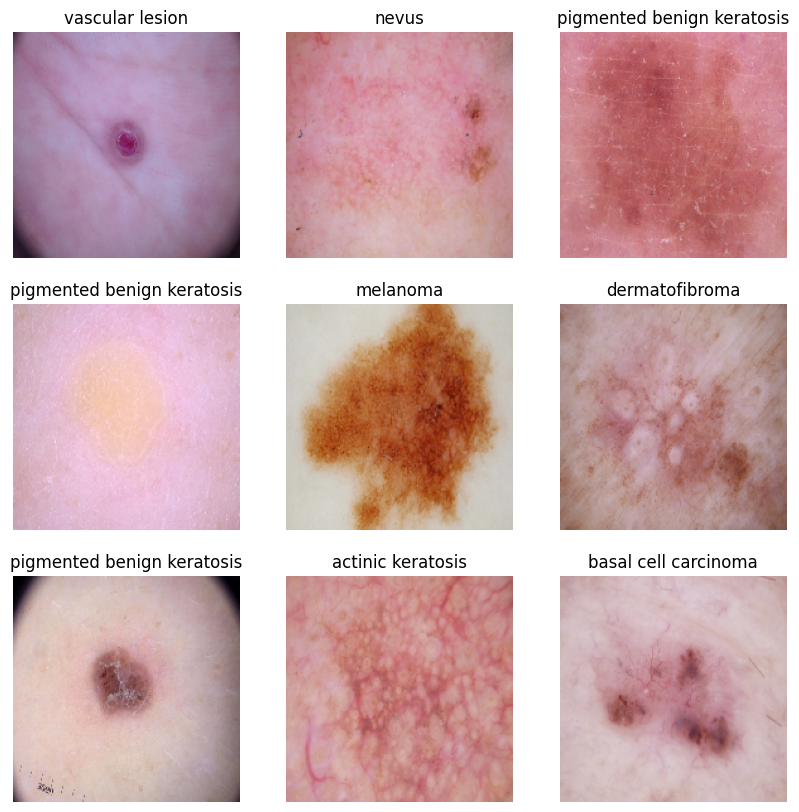

In [48]:
import matplotlib.pyplot as plt

# Plotting the images from train dataset of each class
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  plt.show()  



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [49]:
# Printing the shape of the images
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [55]:
# Normalizing the pixel values
num_classes = len(class_names)
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
  layers.MaxPool2D(pool_size=(2,2)),
  layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
  layers.MaxPool2D(pool_size=(2,2)),
  layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
  layers.MaxPool2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [56]:
# Compiling the model
# We are using Adam optimizer and SparseCategoricalCrossentropy as loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [57]:
# View the summary of all layers
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 41, 41, 128)      

### Train the model

Training the model, itearting for 20 epochs. First we are training the model on train dataset and then validating it on test dataset

In [58]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


70/70 [==============================] - 60s 840ms/step - loss: 1.9231 - accuracy: 0.2894 - val_loss: 2.2650 - val_accuracy: 0.3051
Epoch 2/20
70/70 [==============================] - 62s 882ms/step - loss: 1.5654 - accuracy: 0.4417 - val_loss: 2.3077 - val_accuracy: 0.2966
Epoch 3/20
70/70 [==============================] - 62s 882ms/step - loss: 1.4741 - accuracy: 0.4900 - val_loss: 1.9844 - val_accuracy: 0.3051
Epoch 4/20
70/70 [==============================] - 57s 810ms/step - loss: 1.3241 - accuracy: 0.5413 - val_loss: 2.2214 - val_accuracy: 0.3390
Epoch 5/20
70/70 [==============================] - 57s 811ms/step - loss: 1.2677 - accuracy: 0.5534 - val_loss: 2.0664 - val_accuracy: 0.2627
Epoch 6/20
70/70 [==============================] - 57s 813ms/step - loss: 1.2089 - accuracy: 0.5730 - val_loss: 2.1210 - val_accuracy: 0.2966
Epoch 7/20
70/70 [==============================] - 57s 818ms/step - loss: 1.1255 - accuracy: 0.5994 - val_loss: 2.0141 - val_accuracy: 0.3898
Epoch 8/20

### Visualizing training results

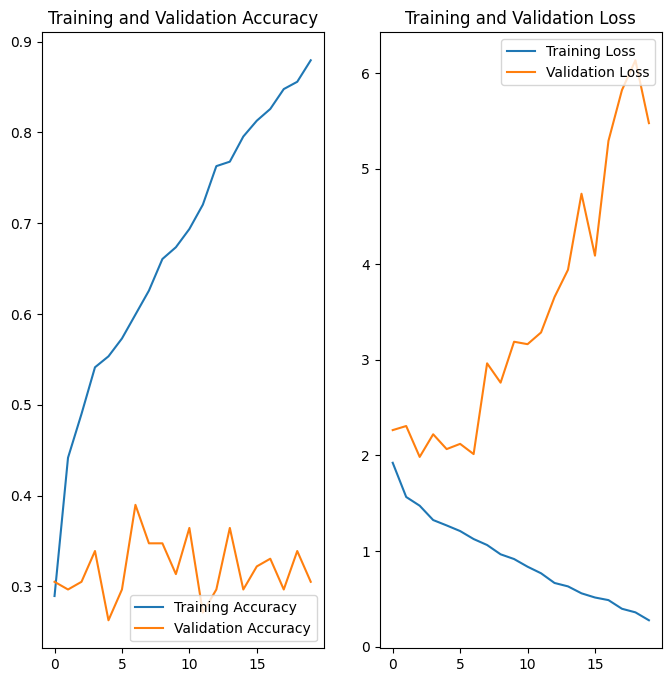

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The training result shows that the model has overfitting issue and the validation loss has increased on each epoch iterations.

### Write your findings here

In [60]:
# Data Augmentation, we are using RandomFlip, RandomRotation and RandomZoom to augment the data
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

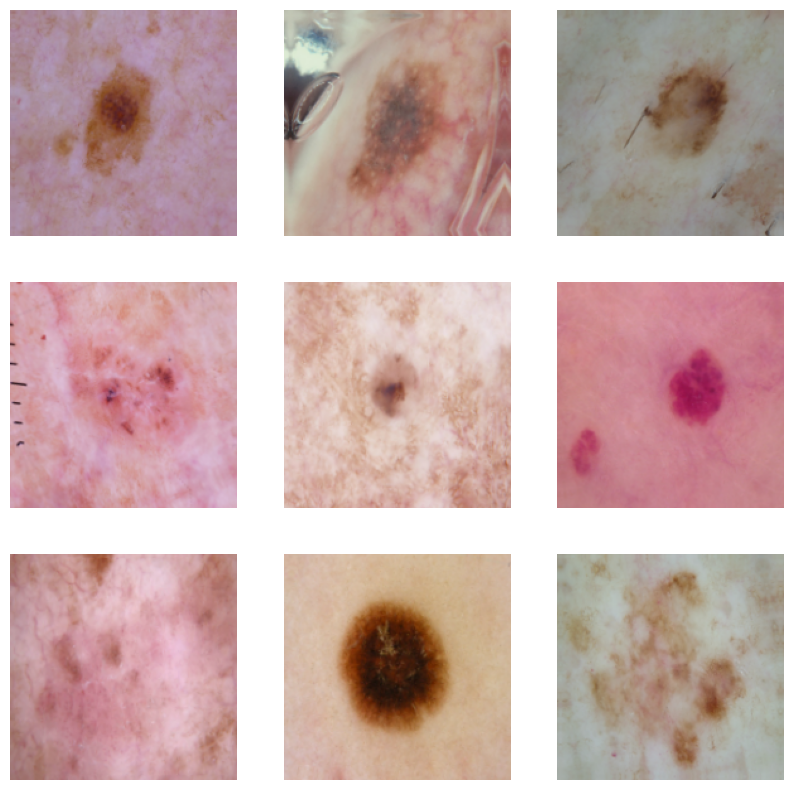

In [61]:
# Plotting the augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")
plt.show()



### Creating the model on augmentation of the image dataset and training the model.

In [62]:
# Creating the model with data augmentation, also adding dropout layers to avoid overfitting
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  ## Add more layers here
  layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
  layers.MaxPool2D(pool_size=(2,2)),
  layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
  layers.MaxPool2D(pool_size=(2,2)),
  layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
  layers.MaxPool2D(pool_size=(2,2)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes, activation='softmax')
])


In [63]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                

### Training the model

In [65]:
## Your code goes here
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


70/70 [==============================] - 68s 917ms/step - loss: 1.9792 - accuracy: 0.2827 - val_loss: 2.3158 - val_accuracy: 0.2373
Epoch 2/20
70/70 [==============================] - 62s 888ms/step - loss: 1.7046 - accuracy: 0.3841 - val_loss: 2.3642 - val_accuracy: 0.3644
Epoch 3/20
70/70 [==============================] - 63s 902ms/step - loss: 1.5263 - accuracy: 0.4681 - val_loss: 2.5187 - val_accuracy: 0.3390
Epoch 4/20
70/70 [==============================] - 67s 959ms/step - loss: 1.4518 - accuracy: 0.4958 - val_loss: 2.3826 - val_accuracy: 0.3390
Epoch 5/20
70/70 [==============================] - 63s 904ms/step - loss: 1.4383 - accuracy: 0.4962 - val_loss: 2.1699 - val_accuracy: 0.2966
Epoch 6/20
70/70 [==============================] - 65s 935ms/step - loss: 1.3679 - accuracy: 0.5261 - val_loss: 2.0754 - val_accuracy: 0.3051
Epoch 7/20
70/70 [==============================] - 66s 937ms/step - loss: 1.3722 - accuracy: 0.5145 - val_loss: 2.3421 - val_accuracy: 0.3305
Epoch 8/20

### Training the model

### Visualizing the results

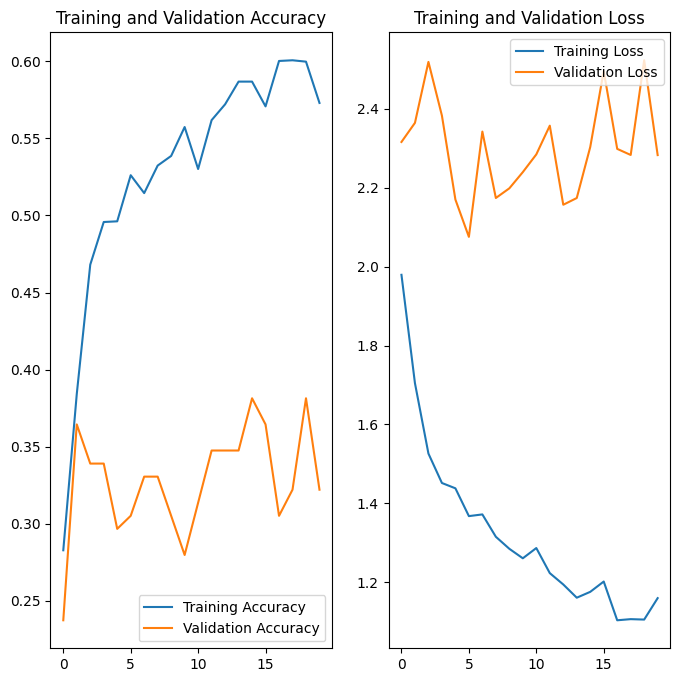

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### By using the data augmentation with flipping, rotating and zooming the images, we can see that we got training accuracy of 57% and validation accuracy of 32%, this means model is underfit.

#### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [67]:
# Find the distribution of the classes in the training dataset
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


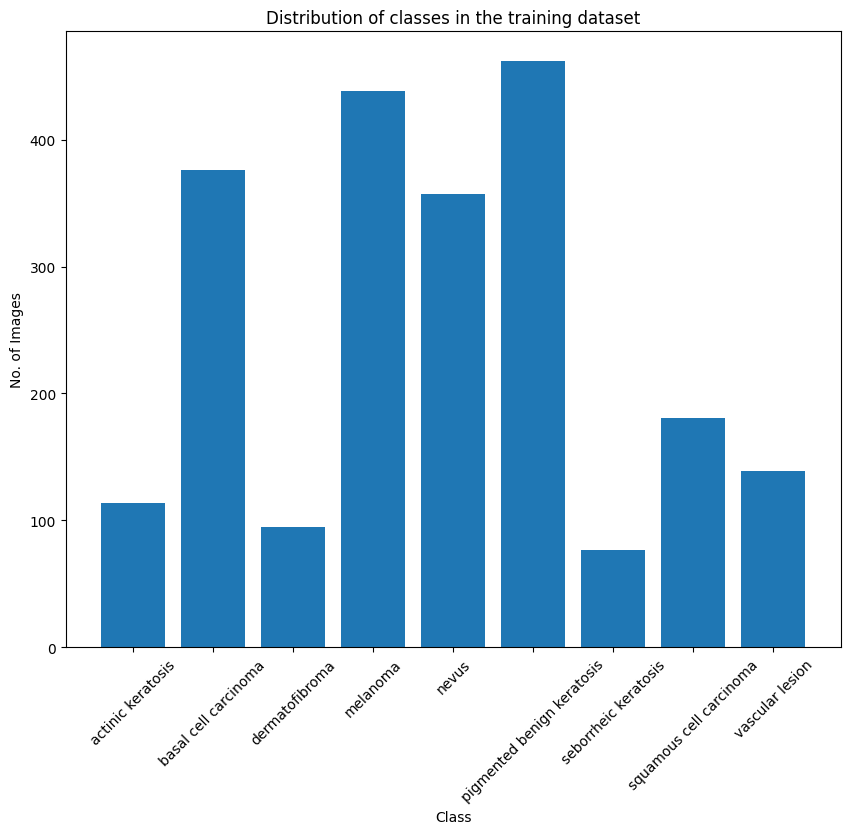

In [106]:
# Plotting the distribution of classes in the training dataset
plt.figure(figsize=(10, 8))
plt.title('Distribution of classes in the training dataset')

# Using matplotlib to plot the bar chart
plt.bar(df['Class'], df['No. of Image'])

plt.xlabel('Class')
plt.ylabel('No. of Images')
plt.xticks(rotation=45)
plt.show()


#### - From above result we can see that images in each class are not in equal count
#### - The class `seborrheic keratosis` is having the least amount of samples,
#### - The class `pigmented bengin keratosis` is having the highest amount of samples present in dataset.


#### Rectify the class imbalance
#### Let's re-sample all the classes with the help of Augmentor library. We'll add 500 samples to each classes and see if the model accuracy is improved or not.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [68]:
# Augmenting the data using Augmentor
path_to_training_dataset='ImageDataset/Train/'
import Augmentor
# We are adding 500 samples per class to make sure that none of the classes are sparse.
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ImageDataset/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1ACE69C6B90>: 100%|██████████| 500/500 [00:04<00:00, 118.91 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to ImageDataset/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1ACE69F51B0>: 100%|██████████| 500/500 [00:04<00:00, 114.53 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to ImageDataset/Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1ACD8BC0E20>: 100%|██████████| 500/500 [00:04<00:00, 117.00 Samples/s]


Initialised with 438 image(s) found.
Output directory set to ImageDataset/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1ACE69C6440>: 100%|██████████| 500/500 [00:21<00:00, 23.71 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to ImageDataset/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x1ACD36B9660>: 100%|██████████| 500/500 [00:18<00:00, 26.84 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to ImageDataset/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1ACD829A2C0>: 100%|██████████| 500/500 [00:05<00:00, 95.40 Samples/s]                   


Initialised with 77 image(s) found.
Output directory set to ImageDataset/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1ACD30773A0>: 100%|██████████| 500/500 [00:09<00:00, 54.40 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to ImageDataset/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1ACD34FE0B0>: 100%|██████████| 500/500 [00:04<00:00, 107.20 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to ImageDataset/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1ACD30754E0>: 100%|██████████| 500/500 [00:04<00:00, 109.10 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [69]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [70]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['ImageDataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_1cd70431-6624-490a-8821-4e5230c00378.jpg',
 'ImageDataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3c2e4799-3e70-4971-a828-1bc066e655f6.jpg',
 'ImageDataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a8e83af7-4afe-4cda-9926-fcf498fd8fab.jpg',
 'ImageDataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_d39bc453-fec3-4b21-932c-77a4b1a6d674.jpg',
 'ImageDataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_0b036edc-77b2-4d8d-9f73-8fd06062c798.jpg',
 'ImageDataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_23b72620-6a67-47da-94df-aa2ec6cbadc8.jpg',
 'ImageDataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_3acc62bf-635b-4ab7-aeaa-7242bb72a010.jpg',
 'ImageDataset\\Train\\actinic keratosis\

In [71]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [72]:
# Creating a new dataframe with augmented images
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [73]:
original_data = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(original_data)

2239

In [74]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(lesion_list)

2239

In [75]:
# Creating a new dataframe with original images
original_dataframe_dict = dict(zip(original_data, lesion_list))
original_df = pd.DataFrame(list(original_dataframe_dict.items()),columns = ['Path','Label'])
original_df.count()

Path     2239
Label    2239
dtype: int64

In [76]:
# Adding the augmented data to the original dataframe
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

C:\Users\arloh\AppData\Local\Temp\ipykernel_18632\390629722.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [77]:
new_df

,Path,Label
0,ImageDataset\Train\actinic keratosis\ISIC_0025...,actinic keratosis
1,ImageDataset\Train\actinic keratosis\ISIC_0025...,actinic keratosis
2,ImageDataset\Train\actinic keratosis\ISIC_0025...,actinic keratosis
3,ImageDataset\Train\actinic keratosis\ISIC_0025...,actinic keratosis
4,ImageDataset\Train\actinic keratosis\ISIC_0025...,actinic keratosis
...,...,...
4495,ImageDataset\Train\vascular lesion\output\vasc...,vascular lesion
4496,ImageDataset\Train\vascular lesion\output\vasc...,vascular lesion
4497,ImageDataset\Train\vascular lesion\output\vasc...,vascular lesion
4498,ImageDataset\Train\vascular lesion\output\vasc...,vascular lesion


In [78]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [79]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset
#### Splitting the dataset, training data is 80% and 20% testing data.

In [80]:
# "path to directory with training data + data created using augmentor"
data_dir_train = pathlib.Path("ImageDataset/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [81]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Training the model with including the images added by Augmentor

In [85]:

num_classes = len(class_names)
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
  layers.MaxPool2D(pool_size=(2,2)),
  layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
  layers.MaxPool2D(pool_size=(2,2)),
  layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
  layers.MaxPool2D(pool_size=(2,2)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes, activation='softmax')
])

In [86]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### While training the model this time, we've increased the epochs to 30 

In [87]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


169/169 [==============================] - 178s 1s/step - loss: 1.9495 - accuracy: 0.2567 - val_loss: 1.7636 - val_accuracy: 0.3400
Epoch 2/30
169/169 [==============================] - 173s 1s/step - loss: 1.5268 - accuracy: 0.4204 - val_loss: 1.3572 - val_accuracy: 0.4922
Epoch 3/30
169/169 [==============================] - 199s 1s/step - loss: 1.3480 - accuracy: 0.4905 - val_loss: 1.3058 - val_accuracy: 0.5152
Epoch 4/30
169/169 [==============================] - 174s 1s/step - loss: 1.2092 - accuracy: 0.5467 - val_loss: 1.3076 - val_accuracy: 0.5093
Epoch 5/30
169/169 [==============================] - 177s 1s/step - loss: 1.1304 - accuracy: 0.5822 - val_loss: 1.1010 - val_accuracy: 0.5924
Epoch 6/30
169/169 [==============================] - 180s 1s/step - loss: 1.0122 - accuracy: 0.6226 - val_loss: 1.0018 - val_accuracy: 0.6303
Epoch 7/30
169/169 [==============================] - 182s 1s/step - loss: 0.8898 - accuracy: 0.6643 - val_loss: 0.9685 - val_accuracy: 0.6414
Epoch 8/30

####  Visualize the model results

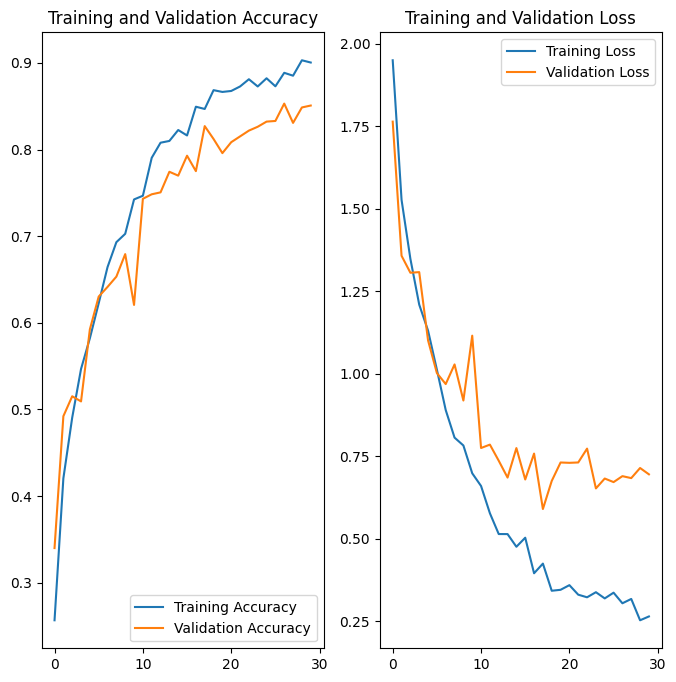

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### From the above result we have received the training accuracy of 90% and Validation accuracy of 85%. Also the validation loss has also decreased gradually per each epoch. We can conclude that the model accuracy has increased with the help of class re-balancing. And overfitting issues have also resolved with the help of class re-balance.



#### We can predict the Model by giving the image to the model and see the Predictive class result.

1/1 [==============================] - 0s 32ms/step
Predictive Class nevus


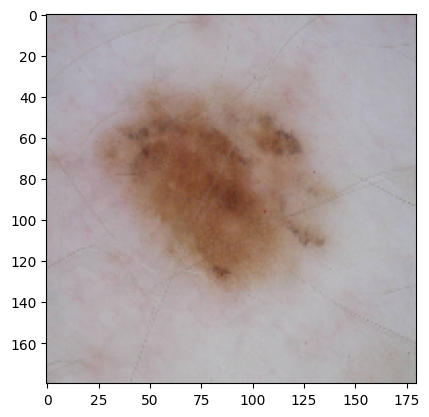

In [99]:
from tensorflow.keras.preprocessing.image import load_img

Test_image_path = os.path.join(data_dir_test, class_names[4], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Predictive Class "+pred_class )